# A Software Package for Simulating and Visualising Load Balancing Algorithms

This Notebook provides a) example usage of the software package and b) the required code to recreate the paper's results. To begin using the software package, the `core` and `simulation` packages need to be imported.

In these examples, the API's classes from the `simulation` package are imported into the current namespace. The `core` package has been imported under the alias `lb` (for load balancer).

In [1]:
import load_balancing.core as lb
from load_balancing.simulation import Simulation, ParallelSimulation, SimulationResult

# We can also import the suggested matplotlib style parameters
from load_balancing import mpl_style
from load_balancing.utils import available_cores

The following imports are used by the notebook to run and visualise the experiments.

* `matplotlib` is used to plot charts
* `numpy` is used for math functions and to generate distributions
* `tikzplotlib` is used to output plots to a .TeX file

In [2]:
import matplotlib.colors
import matplotlib.pyplot as plt
import matplotlib.style

# Initialise matplotlib for Jupyter Notebook and set style parameters
%matplotlib inline
matplotlib.style.use(mpl_style)  # type: ignore

import colorsys
from dataclasses import asdict
from functools import partial

# Used for a custom multiprocessing implementation
from multiprocessing import Pool
from operator import itemgetter
from typing import Callable, List, Tuple

import numpy as np
import tikzplotlib
from IPython.display import Markdown, display
from tabulate import tabulate

A few helper functions are defined for use in the notebook.

In [3]:
def fig_to_tex(fig, filename: str):
    """Save a Matplotlib Figure to a .TeX file

    :param fig: Figure that should be saved
    :type fig: plt.Figure
    :param filename: Name of file to save to
    :type filename: str
    """
    tikzplotlib.clean_figure(fig)
    tikzplotlib.save(filename, figure=fig)


def plot_attributes(
    results: List[SimulationResult], x: str = "m", y: str = "maximum_load"
) -> Tuple[Tuple, Tuple]:
    """Convert a list of SimulationResult to two lists for the given attributed.

    :param results: List of simulation results
    :type results: List[SimulationResult]
    :param x: Attribute to be returned as xs, defaults to "m"
    :type x: str, optional
    :param y: Attribute to be returned as ys, defaults to "maximum_load"
    :type y: str, optional
    :return: Tuple of xs, ys
    :rtype: Tuple[Tuple, Tuple]
    """
    xs, ys = zip(*[(getattr(result, x), getattr(result, y)) for result in results])
    return xs, ys


def plot_gap(results: List[SimulationResult], x: str = "m") -> Tuple[Tuple, Tuple]:
    """Convert a list of SimulationResult to two lists containing the gap between maximum and minimum load.
    Similar to the plot_attribute function.

    :param results: List of simulation results
    :type results: List[SimulationResult]
    :param x: Attribute to be returned as xs, defaults to "m"
    :type x: str, optional
    :return: Typle of xs, ys
    :rtype: Tuple[Tuple, Tuple]
    """
    xs, ys = zip(
        *[
            (getattr(result, x), result.maximum_load - result.minimum_load)
            for result in results
        ]
    )
    return xs, ys


def plot_function(min: float, max: float, f: Callable, num=1000) -> Tuple[List, List]:
    """Helper function to plot a function, useful to visualise bounds

    :param min: Value to plot from
    :type min: float
    :param max: Value to plot to
    :type max: float
    :param f: Function such that y = f(x)
    :type f: Callable
    :param num: Number of points, defaults to 1000
    :type num: int
    :return: Tuple of xs, ys
    :rtype: Tuple[List, List]
    """
    xs = list(np.linspace(min, max, num))
    ys = []
    for x in xs:
        ys.append(f(x))
    return xs, ys


def lighter(hex: str) -> Tuple[float, float, float]:
    """Return a lighter version of hex

    :param hex: Colour hex code
    :type hex: str
    :return: Lighter colour tuple
    :rtype: Tuple[float, float, float]
    """
    h, l, s = colorsys.rgb_to_hls(*matplotlib.colors.ColorConverter.to_rgb(hex))
    return colorsys.hls_to_rgb(h, min(1, l * 1.6), s=s)


def display_results_as_table(results: List[SimulationResult], head=False):
    """Display a list of SimulationResult as a table

    :param results: List of results
    :type results: List[SimulationResult]
    """
    if head:
        results = results[0:5]
        display(Markdown("Top 5 rows:"))
    display(
        tabulate(
            [asdict(result) for result in results], headers="keys", tablefmt="html"
        )
    )

### Describing the simple Greedy[d] algorithm.

To describe the `greedy[d]` algorithm, write the algorithm as a function using the `load_balancing.core` API.

Here we choose $d$ bins from the list of bins, and return the least loaded of the $d$ bins.

In [4]:
def my_greedy_d(ball: lb.Ball, bins: lb.Bins, d: int):
    chosen_bins = bins.choose(d)
    return chosen_bins.min()

### Run a simulation

To run this as a simulation, pass the algorithm to the `Simulation` class and call it like a function. Make sure the number of balls $m$ and bins $n$ are provided. The `greedy[d]` parameter, $d$, is added to the end of the function arguments.

In this experiment we will simulate 100,000 balls and bins.

In [5]:
my_greedy_d_sim = Simulation(my_greedy_d)

experiment_result = my_greedy_d_sim(100000, 100000, 2)

display_results_as_table([experiment_result])

m,n,maximum_load,minimum_load,std_load,load_accesses
100000,100000,4,0,0.703264,200000


### A more complicated algorithm

The `greedy[d]` algorithm is rather simple to describe and doesn't show the power of the simulation system. In the next cell we describe the `always-go-left` algorithm and run the same simulation.

In [6]:
def my_always_go_left(ball: lb.Ball, bins: lb.Bins):
    left_bins, right_bins = bins.split(2)
    left_bin = left_bins.choose_one()
    right_bin = right_bins.choose_one()
    if left_bin.load <= right_bin.load:  # this is where the unfair tie-breaking is
        return left_bin
    else:
        return right_bin


my_always_go_left_sim = Simulation(my_always_go_left)

experiment_result = my_always_go_left_sim(100000, 100000)
display_results_as_table([experiment_result])

m,n,maximum_load,minimum_load,std_load,load_accesses
100000,100000,3,0,0.684485,200000


We can already see an improvement in the maximum load of any bin after this experiment.

## Paper Results

In this section we will use the simulation to recreate the results from the paper. An associated `algorithms.py` file will be used for the implementations. This is because the system requires functions to be defined in a Python file for parallelisation.

In [7]:
from algorithms import (
    uniform,
    greedy_d,
    always_go_left,
    fair_tiebreak,
    one_plus_beta,
    threshold,
    adaptive,
)

The following flag can be set to True to run the larger experiments that were used in the paper. Otherwise, smaller experiments will be run to save time.

In [8]:
USE_LARGE_NUMBERS = True

#### 4.1 Uniform Load Balancing

We will use the `ParallelSimulation` class to take advantage of the multicore processor. In this case it will be used with only one algorithm.

The warning is shown when the class is used in a notebook (like this one) and can be safely ignored since we are loading algorithms from a file.

```python
def uniform(ball: lb.Ball, bins: lb.Bins):
    """Select a bin at random"""
    return bins.choose_one()
```

In [9]:
uniform_sim = ParallelSimulation((uniform, []))

low = 100
high = 70000100 if USE_LARGE_NUMBERS else 7000

experiment_results = uniform_sim.run(low, high, num=40, repeats=5)
uniform_result = experiment_results["uniform"]

display_results_as_table(uniform_result, head=True)

Using 6 processes to run 40 jobs


  0%|          | 0/40 [00:00<?, ?it/s]

Top 5 rows:

m,n,maximum_load,minimum_load,std_load,load_accesses
100,70000100,1,0,0.00119523,0
141,70000100,1,0,0.00141925,0
199,70000100,1,0,0.00168607,0
281,70000100,1,0,0.00200356,0
397,70000100,1,0,0.00238147,0


The following code shows how this data can be plotted on a chart using the library.

We will use the `plot_function` method to plot the bounds $\frac{\log n}{\log \frac{n \log n}{m}} \left( 1 + \alpha \frac{\log \log \frac{n \log n}{m}}{\log \frac{n \log n}{m}} \right)$ for different values of $\alpha$

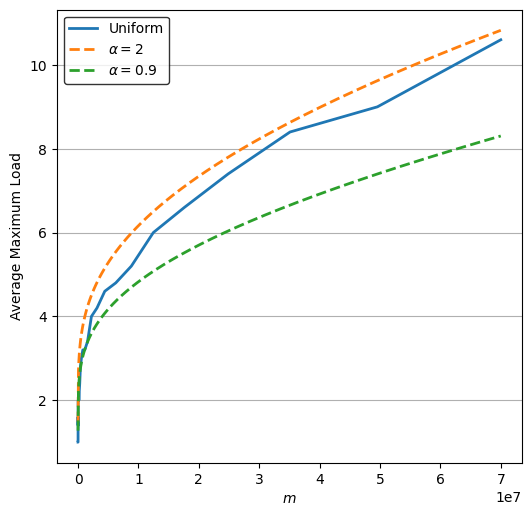

In [10]:
fig, ax = plt.subplots()
ax.set_xlabel("$m$")
ax.set_ylabel("Average Maximum Load")

# Plot the results
ax.plot(*plot_attributes(uniform_result), label="Uniform")

# Plot the bounds.
n = high


def uniform_bounds(a):
    logn = np.log(n)

    def func(m):
        lognlognoverm = np.log((n * logn) / m)
        return (logn / lognlognoverm) * (
            1 + a * (np.log(lognlognoverm) / lognlognoverm)
        )

    return func


ax.plot(
    *plot_function(low, high, uniform_bounds(2)), label="$\\alpha = 2$", linestyle="--"
)
ax.plot(
    *plot_function(low, high, uniform_bounds(0.9)),
    label="$\\alpha = 0.9$",
    linestyle="--"
)

# Enable the legend
ax.legend()

# Save to .TeX file
fig_to_tex(fig, "charts/uniform.tex")

#### 4.2 Always-Go-Left

This experiment will produce a bar chart that will be used to verify the results of the Always-Go-Left paper. The results aim to show how asymmetry in the tiebreaking algorithm decreases the average maximum load.

```python
def always_go_left(ball: lb.Ball, bins: lb.Bins):
    """Divide the bins into two halves, and choose a random bin from each. Select the lowest loaded. Tiebreaks: Choose left."""
    left_bins, right_bins = bins.split(2)
    left_bin = left_bins.choose_one()
    right_bin = right_bins.choose_one()
    if left_bin.load <= right_bin.load:
        return left_bin
    else:
        return right_bin

def fair_tiebreak(ball: lb.Ball, bins: lb.Bins):
    """Divide the bins into two halves, and choose a random bin from each. Select the lowest loaded. Tiebreaks: Fair."""
    left_bins, right_bins = bins.split(2)
    left_bin = left_bins.choose_one()
    right_bin = right_bins.choose_one()
    if left_bin.load < right_bin.load:
        return left_bin
    elif left_bin.load > right_bin.load:
        return right_bin
    else:
        if lb.probability(0.5):
            return left_bin
        else:
            return right_bin
```

In [11]:
parallel_simulation = ParallelSimulation(
    (uniform, []), (greedy_d, [2]), (always_go_left, []), (fair_tiebreak, [])
)

# 2^20 if USE_LARGE_NUMBERS else 2^12
m = n = 1048576 if USE_LARGE_NUMBERS else 4096

experiment_results = parallel_simulation(m, n, repeats=100)

Using 4 processes to run 4 jobs


  0%|          | 0/4 [00:00<?, ?it/s]

/Users/danielstone/.pyenv/versions/3.10.2/lib/python3.10/site-packages/tikzplotlib/_cleanfigure.py:200: UserWarning: Cleaning Bar Container (bar plot) is not supported yet.
  warnings.warn("Cleaning Bar Container (bar plot) is not supported yet.")


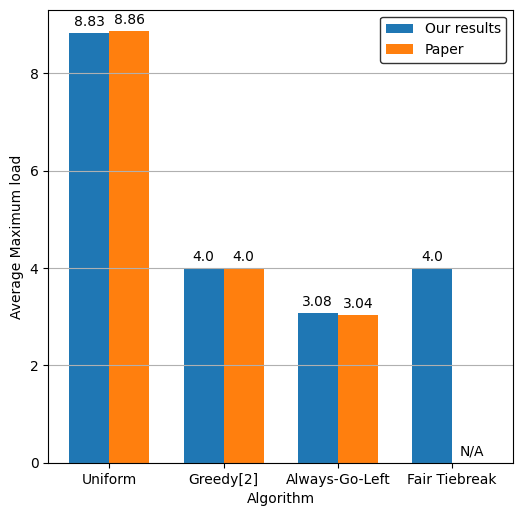

In [12]:
fig, ax = plt.subplots()
ax.set_xlabel("Algorithm")
ax.set_ylabel("Average Maximum load")


def get_maximum_loads(results):
    return [algoritm_results[0].maximum_load for algoritm_results in results.values()]


# Plot the results
labels = ["Uniform", "Greedy[2]", "Always-Go-Left", "Fair Tiebreak"]

x = np.arange(len(labels))
width = 0.35  # Width of the bars

paper_results = [8.86, 4, 3.04, 0] if USE_LARGE_NUMBERS else [6.16, 3.01, 3, 0]

ours = ax.bar(
    x - width / 2, get_maximum_loads(experiment_results), width, label="Our results"
)
paper = ax.bar(x + width / 2, paper_results, width, label="Paper")

# Set the labels
ax.set_xticks(x, labels)

# Enable values on top of the bars
ax.bar_label(ours, [bar.get_height() or "N/A" for bar in ours], padding=3)
ax.bar_label(paper, [bar.get_height() or "N/A" for bar in paper], padding=3)

# Enable the legend
ax.legend()

# Save to .TeX file
fig_to_tex(fig, "charts/always_go_left.tex")

#### 4.3 Distributed Algorithms

In this section, the `greedy[2]` and `uniform` algorithms will be evaluated in a distributed scenario. The corresponding paper states that for the `greedy[2]` algorithm, the expected largest gap between maximum and minimum load of any bin is $\mathcal{O}(\log n)$. For the `uniform` algorithm it is proven to be $\Theta (\sqrt{\frac{m \log n}{n}})$.

Constants will be found so that the experimental data is tightly bounded.

This experiment runs for varying values of n.

In [13]:
experiment_results = {}

high = 1000000
repeats = 20 if USE_LARGE_NUMBERS else 5

for n in [5000, 10000, 15000, 20000]:
    display(Markdown(f"**Running for n = {n}**"))
    parallel_simulation = ParallelSimulation((uniform, []), (greedy_d, [2]))
    experiment_results[n] = parallel_simulation.run(
        n + 1, high, num=40, repeats=repeats, bins=n, balancers=n
    )

**Running for n = 5000**

Using 6 processes to run 80 jobs


  0%|          | 0/80 [00:00<?, ?it/s]

**Running for n = 10000**

Using 6 processes to run 80 jobs


  0%|          | 0/80 [00:00<?, ?it/s]

**Running for n = 15000**

Using 6 processes to run 80 jobs


  0%|          | 0/80 [00:00<?, ?it/s]

**Running for n = 20000**

Using 6 processes to run 80 jobs


  0%|          | 0/80 [00:00<?, ?it/s]

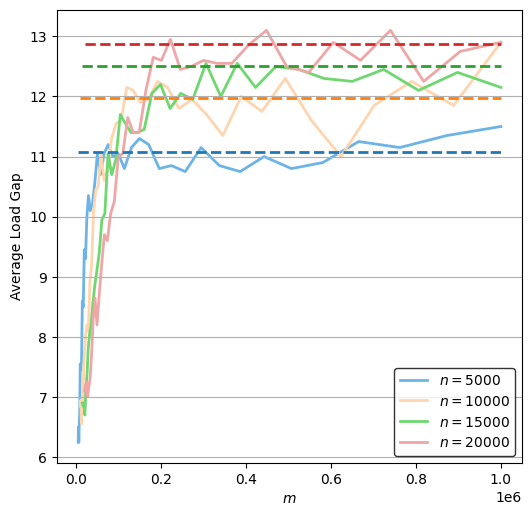

In [14]:
fig, ax = plt.subplots()
ax.set_xlabel("$m$")
ax.set_ylabel("Average Load Gap")

# Plot the bounds.
def distributed_greedy_d_bounds(n):
    logn = np.log(n)

    def func(m):
        return 1.3 * logn

    return func


for n, results in experiment_results.items():
    # Plot the bound in the default colour
    greedy_line = ax.plot(
        *plot_function(n, high, distributed_greedy_d_bounds(n)),
        linestyle="--",
        zorder=2,
    )[0]
    # Plot the data in a lighter colour
    ax.plot(
        *plot_gap(results["greedy_d_2"]),
        label=f"$n = {n}$",
        color=lighter(greedy_line.get_color()),
        zorder=1,
    )

# Enable the legend
ax.legend()

# Save to .TeX file
fig_to_tex(fig, "charts/distributed_greedy.tex")

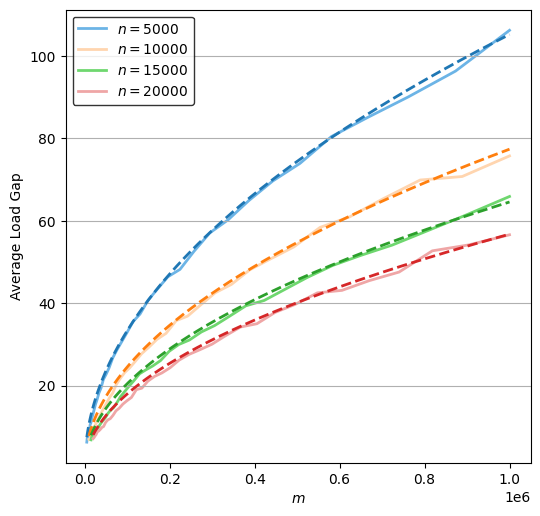

In [15]:
fig, ax = plt.subplots()
ax.set_xlabel("$m$")
ax.set_ylabel("Average Load Gap")

# Plot the bounds.
def distributed_uniform_bounds(n):
    logn = np.log(n)

    def func(m):
        return 2.55 * np.sqrt(m * logn / n)

    return func


for n, results in experiment_results.items():
    # Plot the bound in the default colour
    greedy_line = ax.plot(
        *plot_function(n, high, distributed_uniform_bounds(n)), linestyle="--", zorder=2
    )[0]
    # Plot the data in a lighter colour
    ax.plot(
        *plot_gap(results["uniform"]),
        label=f"$n = {n}$",
        color=lighter(greedy_line.get_color()),
        zorder=1,
    )

# Enable the legend
ax.legend()

# Save to .TeX file
fig_to_tex(fig, "charts/distributed_uniform.tex")

#### 4.4 Weighted Balls

This experiment on `greedy[2]` analyses the average maximum load for a sorted weight distribution as it becomes less sorted.

In [16]:
from sorting_steps import sorting_steps

steps = [100, 200, 500, 1000]

repeats = 10000 if USE_LARGE_NUMBERS else 100

cpu_count = min(len(steps), available_cores())
print(f"Using {cpu_count} processes")

with Pool(cpu_count) as p:
    experiment_results = p.map(partial(sorting_steps, repeats), steps)

Using 4 processes
Number of balls and bins:  100
Number of balls and bins:  200
Number of balls and bins:  500
Number of balls and bins:  1000


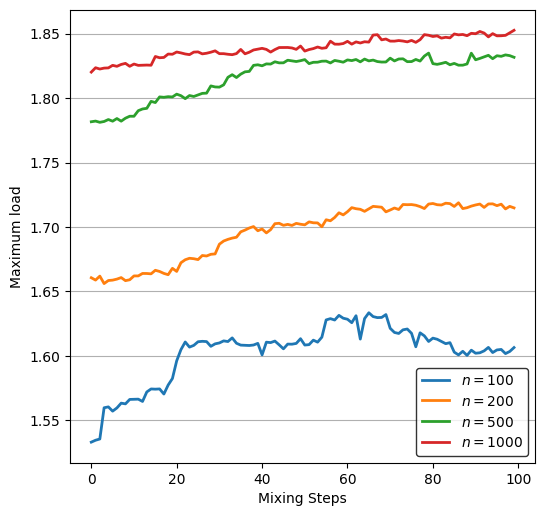

In [17]:
fig, ax = plt.subplots()
ax.set_xlabel("Mixing Steps")
ax.set_ylabel("Maximum load")

for i, result in enumerate(experiment_results):
    ax.plot(*plot_attributes(result, x="mixing_steps"), label=f"$n = {steps[i]}$")

# Enable the legend
ax.legend()

# Save to .TeX file
fig_to_tex(fig, "charts/weighted.tex")

#### 4.4 Communication Complexity

This experiment will compare the communication complexity of the previously seen algorithms, with the `one_plus_beta`, `threshold` and `adaptive` algorithms.

```python

def one_plus_beta(ball: lb.Ball, bins: lb.Bins, p: float):
    """With probability p choose two bins, otherwise choose one at random"""
    if lb.probability(p):
        return bins.choose(2).min()
    else:
        return bins.choose_one()


def threshold(ball: lb.Ball, bins: lb.Bins):
    threshold = ball.m / bins.n + 1
    while True:
        chosen_bin = bins.choose_one()
        if chosen_bin.load < threshold:
            return chosen_bin


def adaptive(ball: lb.Ball, bins: lb.Bins):
    n = bins.n
    while True:
        chosen_bin = bins.choose_one()
        if chosen_bin.load < ball.position / n + 1:
            return chosen_bin
```

In [18]:
communication_complexity_simulation = ParallelSimulation(
    (uniform, []),
    (greedy_d, [2]),
    (one_plus_beta, [0.5]),
    (threshold, []),
    (adaptive, []),
)

# 2^20 if USE_LARGE_NUMBERS else 2^12
m = n = 1048576 if USE_LARGE_NUMBERS else 4096

results = communication_complexity_simulation(m, n, repeats=100)

Using 5 processes to run 5 jobs


  0%|          | 0/5 [00:00<?, ?it/s]

In [19]:
sorted_results = sorted(
    [
        {
            "Algorithm": name,
            "Maximum Load": result[0].maximum_load,
            "Load Access Count": result[0].load_accesses,
        }
        for name, result in results.items()
    ],
    key=itemgetter("Maximum Load"),
    reverse=True,
)

display(tabulate(sorted_results, headers="keys", tablefmt="html"))

Algorithm,Maximum Load,Load Access Count
uniform,8.75,0
one_plus_beta_0.5,7.05,1048480
greedy_d_2,4,2097152
threshold,2,1201901
adaptive,2,1201912
